# Assessment for Advanced Data Science

## Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 29th October 2021



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices. 

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code. 

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total.


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS 

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below. 



In [ ]:
# Install your library here, for example the fynesse template 
# is set up to be pip installable
%pip install git+https://github.com/lawrennd/fynesse_template.git

Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [ ]:
import fynesse

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing in dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*. 

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (11th November 2021). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository. 
  
Call the database you use for this assessment `property_prices`.
  

In [1]:
# Write code for requesting and storing credentials (username, password) here.

from dotenv import load_dotenv
from typing import TypedDict
import os

load_dotenv()

def get_env(key: str) -> str:
  val = os.getenv(key)
  assert val is not None, f"Please make sure to set the {key} environment variable, or put it in .env"
  return val

# Helper class to make the type annotations clearer
class Credentials(TypedDict):
  username: str
  password: str
  host: str
  database_name: str

creds: Credentials = {
  "username": get_env("ADS_DB_USERNAME"),
  "password": get_env("ADS_DB_PASSWORD"),
  "host": get_env("ADS_DB_HOST"),
  "database_name": "property_prices"
}

In [3]:
# Write any other setup code you need for setting up database access here.
import pymysql
from typing import List, Any
from pymysql.connections import Connection

def make_connection(creds: Credentials) -> pymysql.connections.Connection:
  return pymysql.connect(
    user=creds["username"], 
    password=creds["password"], 
    host=creds["host"],
    database=creds["database_name"],
    local_infile=True,
  )

def execute(conn: Connection, sql: str, *args: List[Any]) -> None:
  with conn.cursor() as cur:
    cur.execute(sql, args=args)
  conn.commit()

with make_connection({**creds, "database_name": "mysql"}) as conn:
    execute(conn, "CREATE DATABASE IF NOT EXISTS `property_prices` DEFAULT CHARACTER SET utf8 COLLATE utf8_bin;")

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using 


```
LOCAL DATA LOAD INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module. 

Each 'data part' should be downloadable from the `gov.uk` site and uploadable to your database instance in a couple of seconds. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in a matter of minutes. 

You may find the following schema useful in creation of your database:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key in the database

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

This schema contains data about property sales. It relates the price at which a property was sold to the location and date of sale. It does not contain geographical data such as GPS coordinates, but instead deals with administrative locations (address, post code, etc.). It also assigns a unique ID named `db_id` which increments from 1 with each row. This is used as the primary key for the table.


In [4]:
# Write the code you need for creating the database table and uploading the data here.

from typing import Optional, Tuple
import requests
import os

def upload_file(conn: Connection, table: str, path: str) -> None:
  # This is a potential SQL injection surface
  # but there doesn't seem to be an easy way
  # around it, as PyMySQL always escapes parameters
  # with single quotes (') rather than backticks (`)
  # which causes a syntax error when applied to
  # table names
  execute(
    conn,
    f"""LOAD DATA LOCAL INFILE %s
INTO TABLE `{table}`
FIELDS TERMINATED BY ','
OPTIONALLY ENCLOSED BY '"'
LINES STARTING BY ''
TERMINATED BY '\n';""",
    path
  )

def query(conn: Connection, sql: str, *args: List[Any]) -> Tuple[Tuple[Any]]:
  with conn.cursor() as cur:
    cur.execute(sql, *args)
    return cur.fetchall()

def download_file(url: str, output_path: str) -> None:
  if os.path.exists(output_path):
    print(f"Skipping download of {output_path} because it already exists")
    return
  response = requests.get(url)
  with open(output_path, "wb") as fp:
    fp.write(response.content.strip(b"\n"))
  print(f"Downloaded {output_path}")

In [10]:
def upload_pp_data_file(
  conn: Connection,
  year: int,
  part: Optional[int] = None,
  local_path_template: str = "./pp_data/y%d%s.csv",
  url_template:str = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-%d%s.csv"
) -> None:
  part_str = "" if part is None else f"-part{part}"
  url = url_template % (year, part_str)
  local_path = local_path_template % (year, part_str)
  download_file(url, local_path)
  upload_file(conn, "pp_data", local_path)

with make_connection(creds) as conn:
  execute(conn, "DROP TABLE IF EXISTS `pp_data`;")
  execute(conn, """CREATE TABLE IF NOT EXISTS `pp_data` (
    `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
    `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
    `street` tinytext COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
    `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;""")
  execute(conn, "ALTER TABLE `pp_data` ADD PRIMARY KEY (`db_id`);")
  execute(conn, "ALTER TABLE `pp_data` MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;")

  for year in range(1995, 2022):
    for part in [1,2]:
      upload_pp_data_file(conn, year, part)
  upload_pp_data_file(conn, 2022)

Skipping download of ./pp_data/y1995-part1.csv because it already exists
Skipping download of ./pp_data/y1995-part2.csv because it already exists
Skipping download of ./pp_data/y1996-part1.csv because it already exists
Skipping download of ./pp_data/y1996-part2.csv because it already exists
Skipping download of ./pp_data/y1997-part1.csv because it already exists
Skipping download of ./pp_data/y1997-part2.csv because it already exists
Skipping download of ./pp_data/y1998-part1.csv because it already exists
Skipping download of ./pp_data/y1998-part2.csv because it already exists
Skipping download of ./pp_data/y1999-part1.csv because it already exists
Skipping download of ./pp_data/y1999-part2.csv because it already exists
Skipping download of ./pp_data/y2000-part1.csv because it already exists
Skipping download of ./pp_data/y2000-part2.csv because it already exists
Skipping download of ./pp_data/y2001-part1.csv because it already exists
Downloaded ./pp_data/y2001-part2.csv
Downloaded ./p

In [11]:
print("Expecting to find ", end="")
!echo -n $(expr $(wc -l ./pp_data/*.csv | tail -n1 | sed 's/[^0-9]//g') + $(ls -1 ./pp_data | wc -l))
print(" records...")

with make_connection(creds) as conn:
  num_records = query(conn, "SELECT COUNT(*) FROM `pp_data`")[0][0]
  print(f"Actually found {num_records} records!")

Expecting to find 27641648 records...
Actually found 27641648 records!


### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And you can load the CSV file into the table in one "INFILE".

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```

In [12]:
import zipfile

with make_connection(creds) as conn:
  execute(conn, "DROP TABLE IF EXISTS `postcode_data`;")
  execute(conn, """CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;""")
  execute(conn, "ALTER TABLE `postcode_data` ADD PRIMARY KEY (`db_id`);")
  execute(conn, "ALTER TABLE `postcode_data` MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;")
  execute(conn, "CREATE INDEX idx_postcode_2 ON `postcode_data` (`postcode`);")
  execute(conn, "CREATE INDEX idx_lattitude ON `postcode_data` (`lattitude`);")
  execute(conn, "CREATE INDEX idx_longitude ON `postcode_data` (`longitude`);")

  postcode_data_dir = "postcode_data"
  zip_path = os.path.join(postcode_data_dir, "open_postcode_geo.csv.zip")
  csv_path = os.path.join(postcode_data_dir, "open_postcode_geo.csv")
  
  download_file("https://www.getthedata.com/downloads/open_postcode_geo.csv.zip", zip_path)
  with zipfile.ZipFile(zip_path, "r") as zfp:
    zfp.extractall(postcode_data_dir)

  upload_file(conn, "postcode_data", csv_path)

Downloaded postcode_data/open_postcode_geo.csv.zip


### Task D 

These data can now be joined to form a new table that contains house price paid and latitude longitude of the house. We could create a new table that contains all this information. However, the computation of that table will take some time because of the size of the two existing tables in the join. 

Instead, we're going to exploit the nature of the task. To build our prediction model, we're going to use the prices for a particular region in a given time period. This means we can select that region and time period and build the joined data only from the relevent rows from the two tables. This will save time on the join.

Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would likely be better to store the entired database joined, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better. In that case you can make use of an  *inner join* for this data set creation.

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;


```



In [10]:
import datetime
import dateutil
from dataclasses import dataclass
import numpy as np

@dataclass
class Box:
  lat: float
  lng: float
  min_lat: float
  max_lat: float
  min_lng: float
  max_lng: float
  size_km: float
  date: datetime.datetime
  start_date: datetime.datetime
  end_date: datetime.datetime
  size_days: int

def calculate_box(lat: float, lng: float, size_km: float, date: datetime.datetime, size_days: int) -> Box:
  # Approximation based on https://en.wikipedia.org/wiki/Latitude#Meridian_distance_on_the_ellipsoid
  size_lat_deg = size_km / 110.574
  size_lng_deg = size_km / (111.320 * np.cos(np.deg2rad(lat)))

  date = date.astimezone(datetime.timezone.utc)

  return Box(
    lat,
    lng,
    lat - size_lat_deg/2,
    lat + size_lat_deg/2,
    lng - size_lng_deg/2,
    lng + size_lng_deg/2,
    size_km,
    date,
    date + dateutil.relativedelta.relativedelta(days=-size_days),
    date + dateutil.relativedelta.relativedelta(days=size_days),
    size_days
  )

def join_pp_and_postcode_data(
  conn: Connection,
  box: Box
) -> None:
  execute(conn, "DROP TABLE IF EXISTS `prices_coordinates_data`;")
  execute(conn, """CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;""")
  execute(conn, "ALTER TABLE `prices_coordinates_data` ADD PRIMARY KEY (`db_id`);")
  execute(conn, "ALTER TABLE `prices_coordinates_data` MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;")

  execute(
    conn,
    """INSERT INTO `prices_coordinates_data`
SELECT `price`, `date_of_transfer`, `pp_data`.`postcode`, `property_type`, `new_build_flag`, `tenure_type`, `locality`, `town_city`, `district`, `county`, `country`, `lattitude`, `longitude`, 0
FROM `pp_data`
INNER JOIN `postcode_data`
ON `pp_data`.`postcode`=`postcode_data`.`postcode`
WHERE `lattitude` > %s
AND `lattitude` < %s
AND `longitude` > %s
AND `longitude` < %s
AND `date_of_transfer` > %s
AND `date_of_transfer` < %s""",
    box.min_lat,
    box.max_lat,
    box.min_lng,
    box.max_lng,
    box.start_date,
    box.end_date
  )


In [11]:
box = calculate_box(
  51.509865,
  -0.118092,
  10,
  datetime.datetime(2020, 1, 1, tzinfo=datetime.timezone.utc),
  5
) # London

In [12]:
with make_connection(creds) as conn:
  join_pp_and_postcode_data(
    conn,
    box
  )

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below. 

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [71]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

import osmnx as ox
from geopandas import GeoDataFrame
from typing import Dict
from tqdm import tqdm
import warnings

ox.settings.use_cache = True

default_tags = {
  "amenity": True, 
  "building": True, 
  "historic": True, 
  "leisure": True, 
  "shop": True, 
  "tourism": True,
  "cuisine": True
}
def fetch_pois(box: Box, tags: Dict[str, bool]=default_tags, pbar: Optional[tqdm] = None) -> Dict[datetime.datetime, GeoDataFrame]:
  result: Dict[datetime.datetime, GeoDataFrame] = {}
  date = box.start_date
  while date <= box.end_date:
    overpass_settings = ox.settings.overpass_settings
    if date is not None:
      ox.settings.overpass_settings = overpass_settings + f'[date:"{date.astimezone(datetime.timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")}"]'
    result_for_date = ox.geometries_from_bbox(box.max_lat, box.min_lat, box.min_lng, box.max_lng, tags)
    ox.settings.overpass_settings = overpass_settings
    result[date] = result_for_date
    date += dateutil.relativedelta.relativedelta(days=1)
    if pbar is not None:
      pbar.update()
  return result

def count_pois(pois: Dict[datetime.datetime, GeoDataFrame], box: Box) -> Dict[datetime.datetime, Dict[str, int]]:
  result: Dict[datetime.datetime, Dict[str, int]] = {}
  for date in pois:
    if date < box.start_date or date > box.end_date:
      continue
    pois_date = pois[date]
    
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      lat_series = pois_date["geometry"].centroid.y
      lng_series = pois_date["geometry"].centroid.x
      
    pois_date_area = pois_date[(box.min_lat <= lat_series) & (lat_series <= box.max_lat) & (box.min_lng <= lng_series) & (lng_series <= box.max_lng)]
    result_for_date: Dict[str, int] = {}
    for tag in tags:
      result_for_date[tag] = pois_date_area[tag].notna().sum()
    result[date] = result_for_date
  return result


In [77]:
import pandas as pd

with make_connection(creds) as conn:
  records = query(conn, "SELECT lattitude, longitude, date_of_transfer, property_type, town_city, price FROM prices_coordinates_data")
  df = pd.DataFrame(records, columns=["Lattitude", "Longitude", "Date", "Type", "City", "Price"])

df.head()

,Lattitude,Longitude,Date,Type,City,Price
0,51.51498200,-0.11486300,2019-12-30,F,LONDON,2310000
1,51.51797200,-0.13047600,2019-12-30,F,LONDON,1600000
2,51.52582200,-0.12577500,2019-12-30,F,LONDON,460000
3,51.48926500,-0.15460100,2019-12-30,F,LONDON,8540000
4,51.52203100,-0.07879400,2019-12-30,F,LONDON,1254400


In [76]:
dilation_km = 0.5

dilated_box = calculate_box(
  box.lat,
  box.lng,
  box.size_km+dilation_km,
  box.date,
  box.size_days
)

tags = {"cuisine": True, "shop": True, "public_transport": True}

with tqdm(total=dilated_box.size_days*2+1, leave=False) as pbar:
  pois = fetch_pois(dilated_box, tags, pbar)

In [79]:
def dist_km(lat1: float, lng1: float, lat2: float, lng2: float) -> float:
  # Approximation from https://www.omnicalculator.com/other/latitude-longitude-distance#obtaining-the-distance-between-two-points-on-earth-distance-between-coordinates

  R = 6371

  lat1 = np.deg2rad(lat1)
  lat2 = np.deg2rad(lat2)
  lng1 = np.deg2rad(lng1)
  lng2 = np.deg2rad(lng2)

  return 2 * R * np.arcsin(
    np.sqrt(
      np.sin((lat2-lat1)/2) ** 2 +
      (
        np.cos(lat1) *
        np.cos(lat2) *
        np.sin((lng2 - lng1)/2)**2
      )
    )
  )

In [89]:
df_with_predictors = df.copy()

counts = {}
for tag in tags:
  counts[tag] = []

distance_to_city_center = []

for _, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
  lat = float(row["Lattitude"])
  lng = float(row["Longitude"])
  date = datetime.datetime.combine(row["Date"], datetime.datetime.min.time(), tzinfo=datetime.timezone.utc)
  city = row["City"]

  poi_counts = count_pois(pois, calculate_box(lat, lng, dilation_km, date, 0))

  for tag in tags:
    counts[tag].append(poi_counts[date][tag])
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    city_center = ox.geocode_to_gdf(city).centroid
  distance_to_city_center.append(dist_km(lat, lng, city_center.y[0], city_center.x[0]))


for tag in tags:
  df_with_predictors[tag] = counts[tag]
df_with_predictors["Distance to City Center"] = distance_to_city_center

df_with_predictors.head()

,Lattitude,Longitude,Date,Type,City,Price,cuisine,shop,public_transport,Distance to City Center
0,51.51498200,-0.11486300,2019-12-30,F,LONDON,2310000,20,18,11,1.654265
1,51.51797200,-0.13047600,2019-12-30,F,LONDON,1600000,49,128,22,2.429078
2,51.52582200,-0.12577500,2019-12-30,F,LONDON,460000,23,68,6,3.035119
3,51.48926500,-0.15460100,2019-12-30,F,LONDON,8540000,6,69,10,3.368204
4,51.52203100,-0.07879400,2019-12-30,F,LONDON,1254400,28,62,27,3.197568


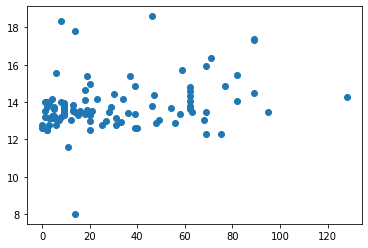

In [232]:
import matplotlib.pyplot as plt

plt.scatter(df_with_predictors["shop"], np.log(df_with_predictors["Price"]))

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction. 

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date. 
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (25th November 2021). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



In [201]:
import statsmodels.api as sm
from typing import Iterable
from sklearn.decomposition import PCA

def calculate_days_since_1995(dates: Iterable[datetime.datetime]) -> List[int]:
  result: List[int] = []
  for date in dates:
    result.append((date - datetime.date(1995, 1, 1)).days)
  return result

def calculate_one_hot_from_property_type(property_types: Iterable[str]) -> Tuple[List[int]]:
  flats: List[int] = []
  semi_detached: List[int] = []
  detached: List[int] = []
  terraced: List[int] = []
  other: List[int] = []

  for t in property_types:
    flats.append(1 if t == "F" else 0)
    semi_detached.append(1 if t == "S" else 0)
    detached.append(1 if t == "D" else 0)
    terraced.append(1 if t == "T" else 0)
    other.append(1 if t == "O" else 0)

  return (flats, semi_detached, detached, terraced, other)

def get_pca_transform(design: np.ndarray) -> PCA:
  return PCA(n_components=design.shape[1]).fit(design)

def make_design(
  lat: Iterable[float],
  lng: Iterable[float],
  date: Iterable[datetime.date],
  property_type: Iterable[str],
  cuisine: Iterable[int],
  shop: Iterable[int],
  public_transport: Iterable[int],
  distance_to_city_center: Iterable[float],
  pca: Optional[PCA] = None
) -> np.ndarray:
  x = np.stack((
    lat,
    lng,
    calculate_days_since_1995(date),
    *calculate_one_hot_from_property_type(property_type),
    cuisine,
    shop,
    public_transport,
    distance_to_city_center,
    np.ones_like(lat)
  )).astype(float).T
  if pca is not None:
    return pca.transform(x)
  return x
  

In [279]:
np.random.seed(1729)

x_train_val = (
  np.array(df_with_predictors["Lattitude"]),
  np.array(df_with_predictors["Longitude"]),
  np.array(df_with_predictors["Date"]),
  np.array(df_with_predictors["Type"]),
  np.array(df_with_predictors["cuisine"]),
  np.array(df_with_predictors["shop"]),
  np.array(df_with_predictors["public_transport"]),
  np.array(df_with_predictors["Distance to City Center"])
)
y_train_val = np.array(df_with_predictors["Price"], dtype=float)

train_prop = 0.8
train_val_num = len(x_train_val[0])
train_num = int(train_val_num * train_prop)
train_val_idxs = np.arange(0, train_val_num)
np.random.shuffle(train_val_idxs)
train_idxs = train_val_idxs[:train_num]
val_idxs = train_val_idxs[train_num:]

x_train = tuple(x_[train_idxs] for x_ in x_train_val)
x_val = tuple(x_[val_idxs] for x_ in x_train_val)

y_train = y_train_val[train_idxs]
y_val = y_train_val[val_idxs]

design_train = make_design(*x_train)
pca = None # get_pca_transform(design_train)
# design_train = pca.transform(design_train)

m_linear_basis = sm.GLM(y_train, design_train, family=sm.families.Gamma(link=sm.families.links.Log()))
results_basis = m_linear_basis.fit()

design_val = make_design(*x_val, pca)

ci = 0.95

y_train_pred = results_basis.get_prediction(design_train).summary_frame(alpha=1-ci)
y_val_pred = results_basis.get_prediction(design_val).summary_frame(alpha=1-ci)

train_rmse = np.sqrt(np.sum((y_train_pred["mean"] - y_train) ** 2))
train_proportion_in_ci = np.mean((y_train_pred["mean_ci_lower"] >= y_train) & (y_train <= y_train_pred["mean_ci_upper"]))

val_rmse = np.sqrt(np.sum((y_val_pred["mean"] - y_val) ** 2))
val_proportion_in_ci = np.mean((y_val_pred["mean_ci_lower"] >= y_val) & (y_val <= y_val_pred["mean_ci_upper"]))

print(train_rmse, train_proportion_in_ci)
print(val_rmse, val_proportion_in_ci)

print(results_basis.summary())

218924000.53092176 0.313953488372093
22039924.684261117 0.4090909090909091
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   86
Model:                            GLM   Df Residuals:                       74
Model Family:                   Gamma   Df Model:                           11
Link Function:                    Log   Scale:                          1.0387
Method:                          IRLS   Log-Likelihood:                -1322.1
Date:                Wed, 23 Nov 2022   Deviance:                       76.560
Time:                        17:51:05   Pearson chi2:                     76.9
No. Iterations:                   100   Pseudo R-squ. (CS):             0.8793
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------